In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#find column names for measurement
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [52]:
# Find the most recent date in the data set.
find_date = session.query(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs).order_by(measurement.date.desc()).all()
most_recent_date = find_date[0][2]
most_recent_date

'2017-08-23'

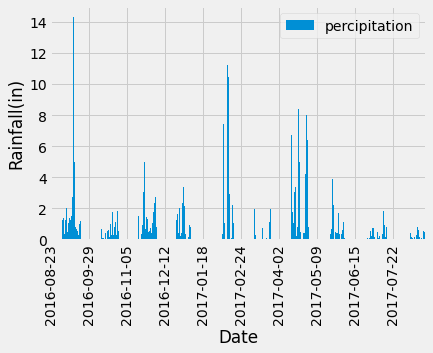

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Perform a query to retrieve the data and precipitation scores

results = engine.execute('SELECT date,prcp FROM measurement WHERE date BETWEEN "2016-08-23" AND "2017-08-23" ORDER BY date')

# Save the query results as a Pandas DataFrame and find sum of percipitation

df = pd.DataFrame(results, columns=['date','percipitation'])
sums_df = df.groupby('date').sum()

# Use Pandas Plotting with Matplotlib to plot the data

percipitation_chart = sums_df.plot(kind = 'bar')
plt.locator_params(axis='x', nbins=10)
plt.ylim(0,15)
percipitation_chart.set_xlabel('Date')
percipitation_chart.set_ylabel('Rainfall(in)');
plt.savefig('rainfall')

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
#find column names for station
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [31]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station.station).count()
station_count

9

In [87]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, station.name,func.count(measurement.tobs)).filter(measurement.station == station.station).\
group_by(measurement.station).order_by(func.count(measurement.tobs).desc()).all()
df2 = pd.DataFrame(active_stations, columns = ['station', 'name','active_count'])
df2

,station,name,active_count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [89]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
weather_report = session.query(station.name,measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
filter(measurement.station == station.station).\
filter(measurement.station == 'USC00519281').all()
df3 = pd.DataFrame(weather_report, columns = ['name', 'station_id','min_temp','max_temp','avg_temp'])
df3

,name,station_id,min_temp,max_temp,avg_temp
0,"WAIHEE 837.5, HI US",USC00519281,54.0,85.0,71.663781


In [115]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp_data = session.query(station.name, measurement.station, measurement.date, measurement.tobs).\
filter(measurement.station == station.station).\
filter(measurement.station == 'USC00519281').\
filter(measurement.date.between('2016-08-23', '2017-08-23')).all()
df4 = pd.DataFrame(year_temp_data, columns = ['name','station_id','date','avg_temp'])
df4

,name,station_id,date,avg_temp
0,"WAIHEE 837.5, HI US",USC00519281,2016-08-23,77.0
1,"WAIHEE 837.5, HI US",USC00519281,2016-08-24,77.0
2,"WAIHEE 837.5, HI US",USC00519281,2016-08-25,80.0
3,"WAIHEE 837.5, HI US",USC00519281,2016-08-26,80.0
4,"WAIHEE 837.5, HI US",USC00519281,2016-08-27,75.0
...,...,...,...,...
347,"WAIHEE 837.5, HI US",USC00519281,2017-08-14,77.0
348,"WAIHEE 837.5, HI US",USC00519281,2017-08-15,77.0
349,"WAIHEE 837.5, HI US",USC00519281,2017-08-16,76.0
350,"WAIHEE 837.5, HI US",USC00519281,2017-08-17,76.0


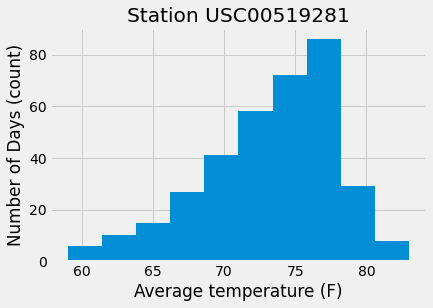

In [116]:
plt.xlabel('Average temperature (F)')
plt.ylabel('Number of Days (count)')
plt.title('Station USC00519281')
df4['avg_temp'].hist();
plt.savefig('histogram_USC00519281')

# Close session

In [117]:
# Close Session
session.close()